In [ ]:
!pip install utils

In [ ]:
get_ipython().system_raw("unrar x Roms")


In [ ]:
!unzip 'HC ROMS.zip'

Archive:  HC ROMS.zip
   creating: HC ROMS/
   creating: HC ROMS/BY ALPHABET/
   creating: HC ROMS/BY ALPHABET (PAL)/
  inflating: HC ROMS/BY ALPHABET (PAL)/======== ROM HUNTER'S HARMONY CART PAL 1977-1992 VCS ROMS COLLECTION V4 ========.txt  
   creating: HC ROMS/BY ALPHABET (PAL)/A-G/
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/208 in 1 Game Select ROM (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/3-D Tic-Tac-Toe (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/Acid Drop (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/Action Man - Action Force (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/Activision Decathlon, The (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/Adventures on GX-12 (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/Air-Sea Battle (PAL).bin  
  inflating: HC ROMS/BY ALPHABET (PAL)/A-G/Airlock (PAL).bin

In [ ]:
import atari_py

In [ ]:
!python -m atari_py.import_roms 'HC ROMS'

copying adventure.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGINALS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying mr_do.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGINALS/Mr. Do! (1983) (CBS Electronics, Ed English) (4L4478) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/mr_do.bin
copying keystone_kapers.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGINALS/Keystone Kapers - Raueber und Gendarm (1983) (Activision, Garry Kitchen - Ariola) (EAX-025, EAX-025-04I - 711 025-725) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/keystone_kapers.bin
copying laser_gates.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGINALS/Laser Gates (AKA Innerspace) (1983) (Imagic, Dan Oliver) (720118-2A, 13208, EIX-007-04I) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/laser_gates.bin
copying king_kong.bin from HC ROMS/PAL VERSIONS OF NTSC ORIGIN

In [ ]:
import os
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym import wrappers
from utils import *
import math

# hyper-parameter.
#EPISODES = 5000
EPISODES = 500


class SumTree:
    def __init__(self, capacity):

        self.capacity = capacity
        self.tree = [0] * (2 * capacity - 1)
        self.data = [None] * capacity
        self.size = 0
        self.curr_point = 0


    def add(self, data):
        self.data[self.curr_point] = data
        self.update(self.curr_point, max(self.tree[self.capacity - 1:self.capacity + self.size]) + 1)

        self.curr_point += 1
        if self.curr_point >= self.capacity:
            self.curr_point = 0

        if self.size < self.capacity:
            self.size += 1


    def update(self, point, weight):
        idx = point + self.capacity - 1
        change = weight - self.tree[idx]
        self.tree[idx] = weight
        parent = (idx - 1) // 2
        while parent >= 0:
            self.tree[parent] += change
            parent = (parent - 1) // 2

    def get_total(self):
        return self.tree[0]


    def get_min(self):
        return min(self.tree[self.capacity - 1:self.capacity + self.size - 1])

    def sample(self, v):
        idx = 0
        while idx < self.capacity - 1:
            l_idx = idx * 2 + 1
            r_idx = l_idx + 1
            if self.tree[l_idx] >= v:
                idx = l_idx
            else:
                idx = r_idx
                v = v - self.tree[l_idx]

        point = idx - (self.capacity - 1)
        return point, self.data[point]


class Memory(object):
    def __init__(self, batch_size, max_size, beta):
        self.batch_size = batch_size
        self.max_size = 2 ** math.floor(math.log2(max_size))
        self.beta = beta
        self._sum_tree = SumTree(max_size)

    def store_transition(self, s, a, r, s_, done):
        self._sum_tree.add((s, a, r, s_, done))

    def get_mini_batches(self):
        n_sample = self.batch_size if self._sum_tree.size >= self.batch_size else self._sum_tree.size
        total = self._sum_tree.get_total()
        points = []
        transitions = []
        step = total // n_sample
        for i in range(n_sample):
            v = np.random.uniform(i * step, (i + 1) * step - 1)
            t = self._sum_tree.sample(v)
            points.append(t[0])
            transitions.append(t[1])
        return points, transitions

    def update(self, points, td_error):
        for i in range(len(points)):
            self._sum_tree.update(points[i], td_error[i])


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.9
        self.learning_rate = 0.01
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
        self.batch_size = 32
        self.train_start = 1000
        self.beta = 0.1
        self.maxlen = 100000
        self.memory = Memory(self.batch_size, self.maxlen, self.beta)

        # create main model
        self.model_target = self.build_model()
        self.model_eval = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # get action from model using epsilon-greedy policy
    def get_action(self, state, step):
        if step > 250:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay
            if self.epsilon<self.epsilon_min:
                self.epsilon=self.epsilon_min
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model_eval.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.store_transition(state, action, reward, next_state, done)

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if self.memory._sum_tree.size < self.train_start:
            return
        batch_size = min(self.batch_size, self.memory._sum_tree.size)
        points, mini_batch = self.memory.get_mini_batches()
        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        td_error = np.zeros(batch_size)
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model_eval.predict(update_input)
        target_val = self.model_target.predict(update_target)

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from model
            if done[i]:
                td_error[i] = abs(reward[i] - target[i][action[i]])
                target[i][action[i]] = reward[i]

            else:
                td_error[i] = abs(reward[i] + self.discount_factor * (np.amax(target_val[i])) - target[i][action[i]])
                target[i][action[i]] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        # and do the model fit!
        self.model_eval.fit(update_input, target, batch_size=self.batch_size,
                            epochs=1, verbose=0)
        self.memory.update(points, td_error)

    def eval2target(self):
        self.model_target.set_weights(self.model_eval.get_weights())


if __name__ == "__main__":
    # load the gym env
    env = gym.make('MsPacman-ram-v0')
    # set  random seeds to get reproduceable result(recommended)
    #set_random_seed(0)
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    # create the agent
    agent = DQNAgent(state_size, action_size)
    # log the training result
    scores, episodes = [], []
    graph_episodes = []
    graph_score = []
    #avg_length = 100
    avg_length = 1
    sum_score = 0
    iteration = 0
    update_times = 0

    # train DQN
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        lives = 3
        while not done:
            dead = False
            step = 0
            while not dead:
                # render the gym env
                if agent.render:
                    env.render()
                step += 1
                # get action for the current state
                action = agent.get_action(state, step)
                # take the action in the gym env, obtain the next state
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state, [1, state_size])
                # judge if the agent dead
                dead = info['ale.lives'] < lives
                lives = info['ale.lives']
                # update score value
                score += reward
                # save the sample <s, a, r, s'> to the replay memory
                agent.append_sample(state, action, reward, next_state, done)
                # train the evaluation network
                if step % 4 == 0:
                    agent.train_model()
                # go to the next state
                state = next_state

            # update the target network after some iterations.
            if update_times >= 2500:
                update_times = 0
                agent.eval2target()
        # print info and draw the figure.
        if done:
            scores.append(score)
            sum_score += score
            episodes.append(e)
            # plot the reward each episode
            # pylab.plot(episodes, scores, 'b')
            print("episode:", e, "  score:", score, "  memory length:",
                  agent.memory._sum_tree.size, "  epsilon:", agent.epsilon,"learning_rate",agent.learning_rate)
        if e % avg_length == 0:
            graph_episodes.append(e)
            graph_score.append(sum_score / avg_length)
            sum_score = 0
            # plot the reward each avg_length episodes
            pylab.plot(graph_episodes, graph_score, 'r')
            pylab.savefig("./pacman_avg.png")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_26 (Dense)             (None, 9)                 297       
Total params: 20,937
Trainable params: 20,937
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                4128      
____________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


episode: 0   score: 210.0   memory length: 634   epsilon: 0.9998613999999999 learning_rate 0.01
episode: 1   score: 160.0   memory length: 1234   epsilon: 0.9998613999999999 learning_rate 0.01
episode: 2   score: 230.0   memory length: 1944   epsilon: 0.998673399999999 learning_rate 0.01
episode: 3   score: 560.0   memory length: 2707   epsilon: 0.9949509999999964 learning_rate 0.01
episode: 4   score: 210.0   memory length: 3277   epsilon: 0.9940995999999958 learning_rate 0.01
episode: 5   score: 140.0   memory length: 3845   epsilon: 0.9940005999999957 learning_rate 0.01
episode: 6   score: 220.0   memory length: 4542   epsilon: 0.9940005999999957 learning_rate 0.01
episode: 7   score: 270.0   memory length: 5201   epsilon: 0.993129399999995 learning_rate 0.01
episode: 8   score: 210.0   memory length: 5807   epsilon: 0.993129399999995 learning_rate 0.01
episode: 9   score: 150.0   memory length: 6416   epsilon: 0.993129399999995 learning_rate 0.01
episode: 10   score: 270.0   memory

In [3]:
import pandas as pd

In [6]:
df = pd.read_excel('results.xlsx')

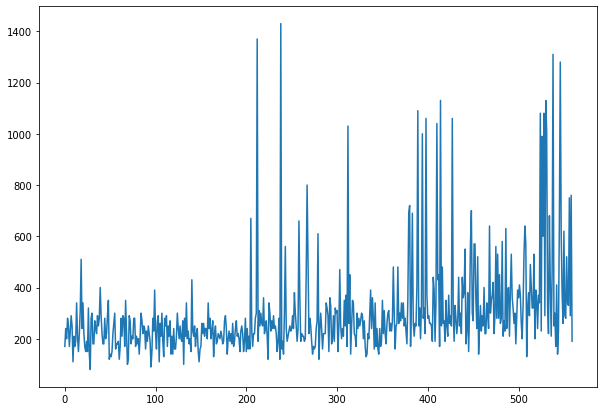

In [38]:
df['d'].plot(figsize=(10,7))

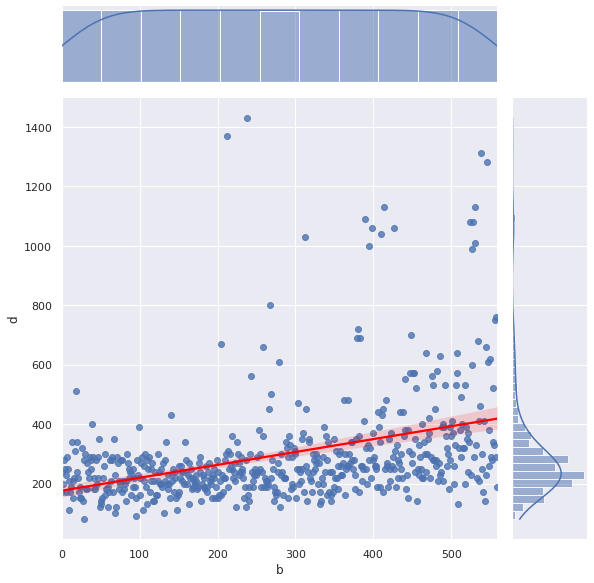

In [44]:
import seaborn as sns
#sns.set(rc={'figure.figsize':(15,8.27)})

sns.jointplot(x='b',y='d',data=df,kind='reg',joint_kws={'line_kws':{'color':'red'}}, height=8.27,) 
